<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />


# Registration of an Image Stack

part of 

<font size = "4"> **pyTEMlib**, a **pycroscopy** library </font>


Notebook by 

Gerd Duscher

Materials Science & Engineering<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville


An Introduction into tegistration of an image stack.

This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1
    
    This test does not require a loading of the packages
    """
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyNSID/ -q
    !pip install git+https://github.com/pycroscopy/sidpy/ -q
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q
else:
    # pyTEMlib setup ------------------
    if test_package('pyTEMlib') < '0.2021.01.04':
        !{sys.executable} -m pip install  --upgrade git+https://github.com/pycroscopy/pyTEMlib
        print('installed pyTEMlib')
    if test_package('sidpy') < '0.0.4':
        !{sys.executable} -m pip install  --upgrade sidpy -q
        print('installed sidpy')
    if test_package('pyNSID') < '0.0.2':
        !{sys.executable} -m pip install  --upgrade  git+https://github.com/pycroscopy/pyNSID -q
        print('Installed pyNSID')
# ------------------------------
print('done')

Installed pyNSID
done


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [6]:
import sys
if 'google.colab' in sys.modules:
    import numpy as np
    from bokeh.layouts import column
    from bokeh.models import CustomJS, Slider
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.models import LinearColorMapper, ColorBar
    output_notebook()
else:    
    %pylab --no-import-all notebook
    %gui qt

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it

#import advanced_image_tools as ait
# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
import pyNSID
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2021_01_03'


Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2021.01.04


## Open File

### Choose Mode of  File Selection

Here you can choose between a ``FileWidget`` or a ``FileDialog`` to select a file.

The FileWidget will use display the name of a Nion File like in NionSwift and is often the better way for those files. 

The ``FileDialog`` does not work on ``Google Colab`` and thus the ``FileWidget`` will be used automatically.

In [4]:
# INPUT choose #
Open_Nion_Directory = True 
drive_directory = ft.get_last_path()
bokeh_plot = False

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    Open_Nion_Directory = True
    drive_directory = 'drive/MyDrive/'
    bokeh_plot = True
elif not ft.QT_available:
    Open_Nion_Directory = True    

### Open file widget
if Open_Nion_Directory:
    file_widget = pyTEMlib.file_tools.FileWidget(drive_directory)

Select(description='Select file:', layout=Layout(width='70%'), options=('.', '..', 'data_06R1XU4U5OUP91H65EJ90…

### Load File

If you did not choose the file widget a File Dialog window will open in the next code cell.

Otherewise just select a File in the widget above

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

In [35]:
try:
    current_channel.file.close()
except:
    pass

if Open_Nion_Directory:
    dataset = pyTEMlib.file_tools.open_file(file_widget.file_name)
else:
    dataset = pyTEMlib.file_tools.open_file()
#dataset.plot()

## in new version delete
import  h5py
h5_file = h5py.File(file_widget.file_name, mode='a')

if dataset.h5_dataset == None:
    dataset.h5_dataset = h5_file[dataset.title]

current_channel = dataset.h5_dataset.parent.parent

found_log = False
for key in current_channel:
    if 'Log' in key:
        if found_log == False:
            print('Stored Results:')
        found_log = True
        for key2 in current_channel[key]:
            if '_metadata' in current_channel[key][key2]: 
                if 'analysis' in current_channel[key][key2]['_metadata'].attrs.keys():
                    print(f" - {key} includes analysis: {current_channel[key][key2]['_metadata'].attrs['analysis']}")

print(current_channel)
# ft.h5_tree(dataset)

print(dataset)
dataset


Stored Results:
 - Log_000 includes analysis: rigid sub-pixel registration
 - Log_001 includes analysis: non-rigid demon registration
 - Log_002 includes analysis: rigid sub-pixel registration
 - Log_003 includes analysis: non-rigid demon registration
<HDF5 group "/Measurement_000/Channel_000" (5 members)>
sidpy.Dataset of type IMAGE_STACK with:
 dask.array<generic, shape=(25, 512, 512), dtype=float32, chunksize=(25, 512, 512), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
frame:  stack (frame) of size (25,)
y:  distance (nm) of size (512,)
x:  distance (nm) of size (512,)


sidpy.Dataset of type IMAGE_STACK with:
 dask.array<generic, shape=(25, 512, 512), dtype=float32, chunksize=(25, 512, 512), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
frame:  stack (frame) of size (25,)
y:  distance (nm) of size (512,)
x:  distance (nm) of size (512,)

### Plot File

<IPython.core.display.Javascript object>


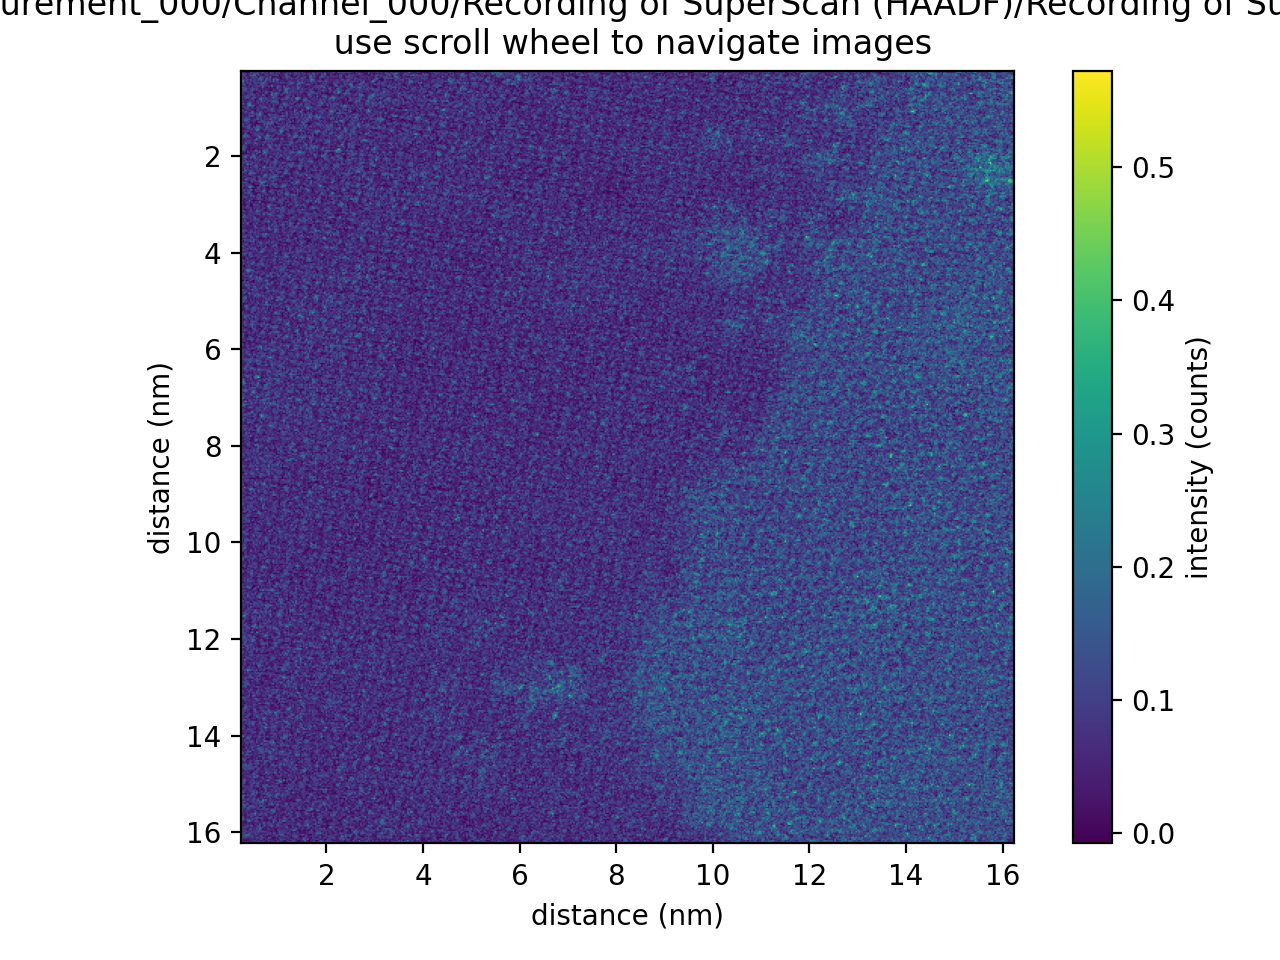

In [8]:
def plot_stack(dataset, palette="Viridis256"):
    stack = np.array(dataset-dataset.min())
    stack = stack/stack.max()*256
    stack = np.array(stack, dtype=int)

    color_mapper = LinearColorMapper(palette=palette, low=0, high=256)

    plot = figure(match_aspect=True, plot_width=600, plot_height=600)
    im_plot = plot.image(image=[stack[0]], x=[0], y=[0], dw=[dataset.x[-1]], dh=[dataset.y[-1]], color_mapper=color_mapper)
    plot.x_range.range_padding = 0
    plot.y_range.range_padding = 0
    plot.xaxis.axis_label = 'distance (nm)'
    plot.yaxis.axis_label = 'distance (nm)'

    slider = Slider(start=0, end=stack.shape[0]-1, value=0, step=1, title="frame")

    update_curve = CustomJS(args=dict(source=im_plot, slider=slider, stack=stack), 
                            code="""var f = slider.value;
                                    source.data_source.data['image'] = [stack[f]];
                                    // necessary becasue we mutated source.data in-place
                                    source.data_source.change.emit(); """)
    slider.js_on_change('value', update_curve)

    return column(slider, plot)


if bokeh_plot:
    p = plot_stack(dataset)
    show(p)
else: 
    dataset.plot()

## First: Rigid Registration

If this is an image stack we need to register and add the images. 

Using sub-pixel accuracy registration determination method of:

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). [DOI:10.1364/OL.33.000156](https://www.doi.org/%2010.1364/OL.33.000156)

as implemented in ``phase_cross_correlation`` function by ``scikit-image`` in the [registration](https://scikit-image.org/docs/dev/api/skimage.registration.html) package. 

Stack contains  25  images, each with 512  pixels in x-direction and  512  pixels in y-direction


<IPython.core.display.Javascript object>


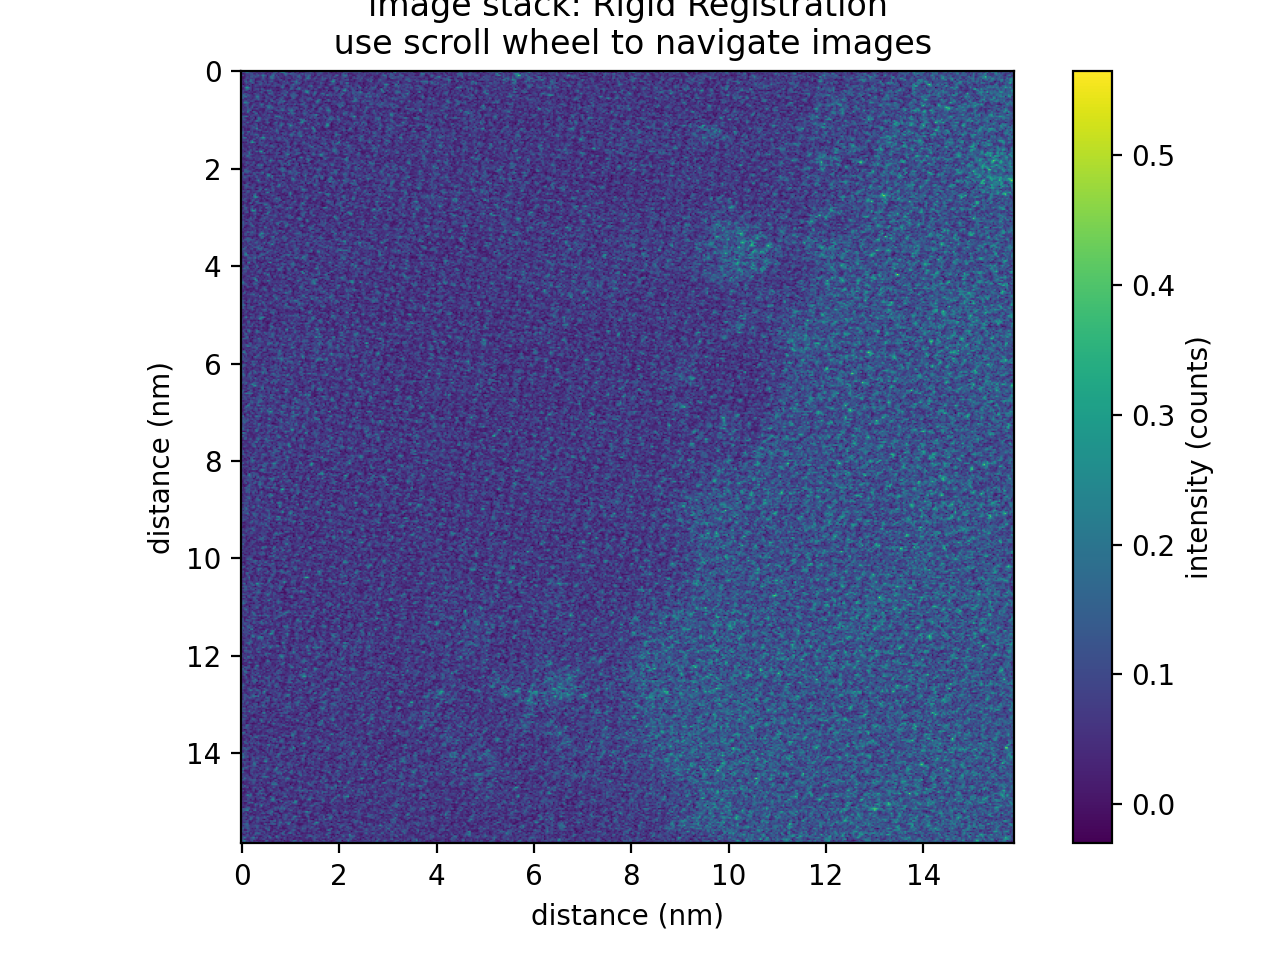

In [9]:
rig_reg_dataset = it.rigid_registration(dataset)

if bokeh_plot:
    p = plot_stack(dataset)
    show(p)
else: 
    dataset.plot()

### Determine Quality of Rigid Registration

First we fit a polynom of degree **polynom_degree** onto the drift of x and y separately.

The Nion STEMs are extremly stable and sub_pixel drift per image can be achieved.

A pixel of size 30pm distributed over 512 pixel (the size of many images) is obviously negletible.

<IPython.core.display.Javascript object>


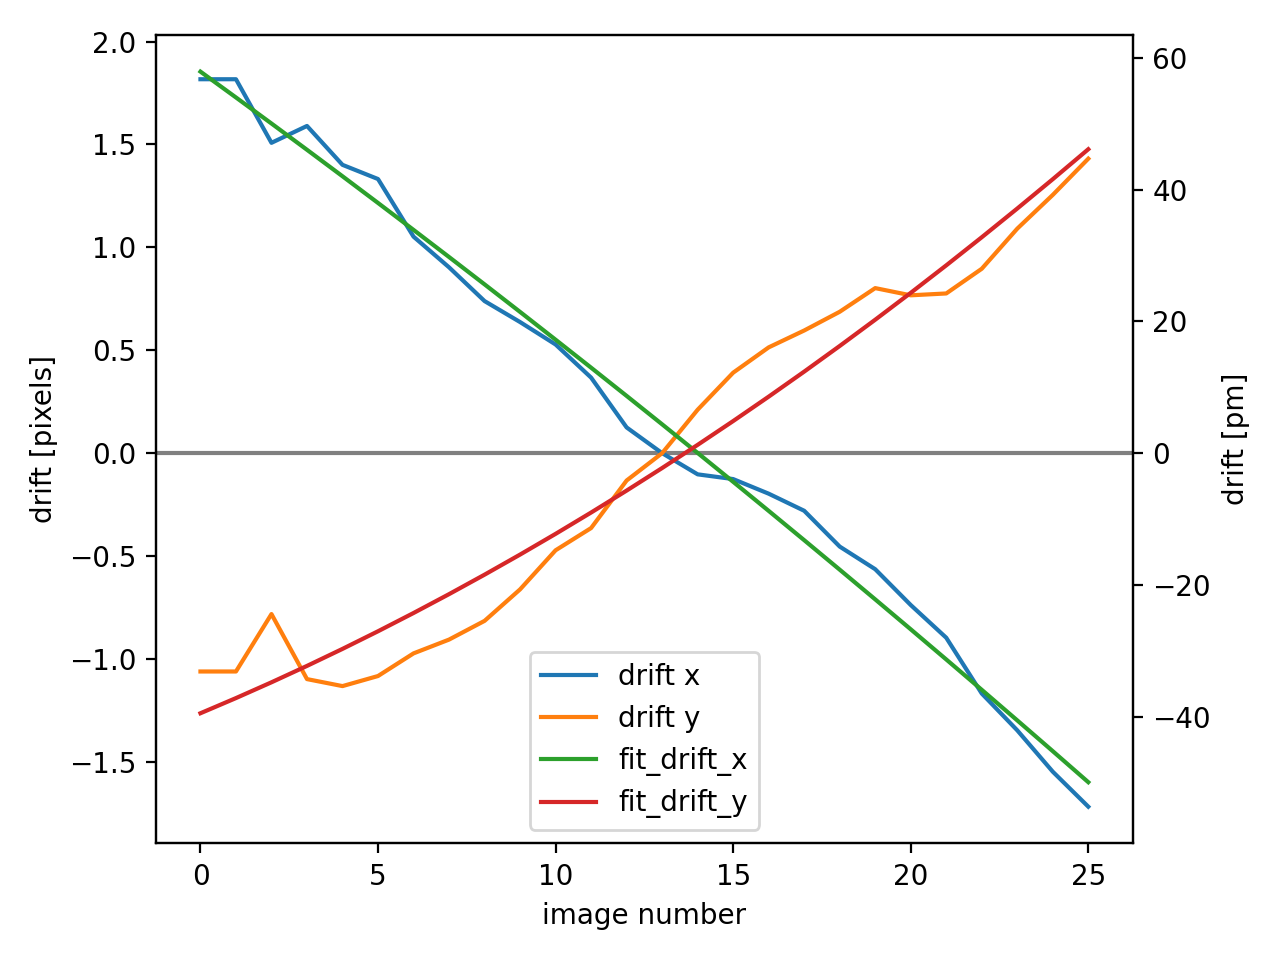

In [10]:
scale_x = ft.get_slope(rig_reg_dataset.x.values)*1000.
drift = rig_reg_dataset.metadata['drift']
x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...
line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)


plt.figure()
# plot drift and fit of drift
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')
plt.legend();

# set second axis in pico meter
ax_pixels = plt.gca()
ax_pixels.step(1, 1)
ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()
ax_pm.set_ylim(x_1*scale_x, x_2*scale_x)

# add labels
ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()


### Contrast
The image should have improved in contrast and signal noise ratio.

<IPython.core.display.Javascript object>


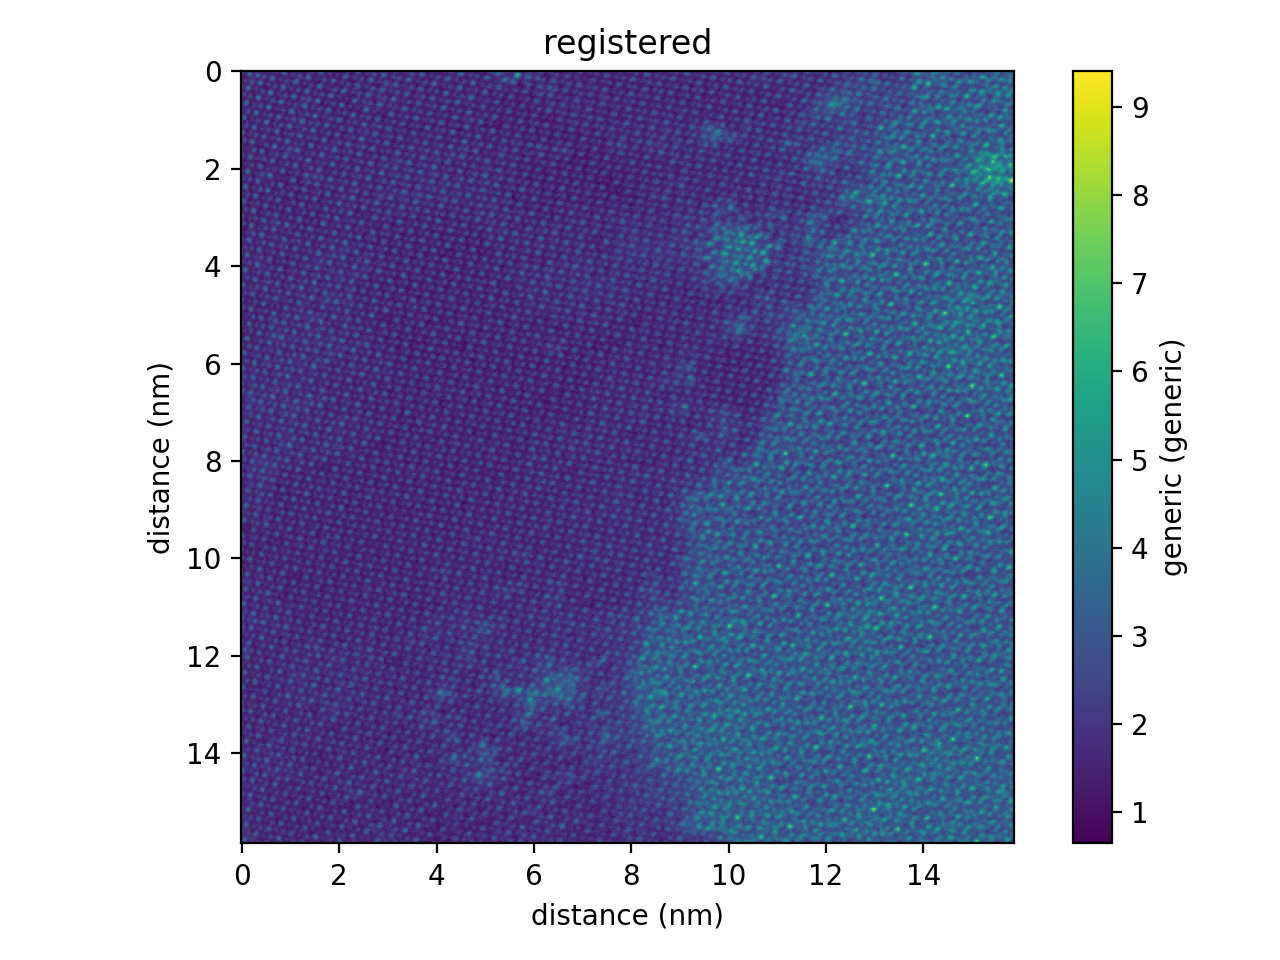

In [16]:
import sidpy

if rig_reg_dataset.data_type.name == 'IMAGE_STACK':
    image = rig_reg_dataset.sum(axis=0)
    image = sidpy.Dataset.from_array(image)
    image.data_type = 'image'
    image.title = 'registered'
    image.set_dimension(0,rig_reg_dataset.dim_1)
    image.set_dimension(1,rig_reg_dataset.dim_2)
else:
    image = dataset

palette="Viridis256"  # "Spectral11"

def image_plot(dataset, palette="Viridis256"):
    
    p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], match_aspect=True,
              plot_width=675, plot_height=600, )
    color_mapper = LinearColorMapper(palette=palette, low=float(np.min(image)), high=float(np.max(image)))

    # must give a vector of image data for image parameter
    p.image(image=[np.array(dataset)], x=0, y=0, dw=dataset.x[-1], dh=dataset.y[-1],  color_mapper=color_mapper, level="image")
    p.x_range.range_padding = 0
    p.y_range.range_padding = 0
    
    p.grid.grid_line_width = 0.
    p.xaxis.axis_label = 'distance (nm)'
    p.yaxis.axis_label = 'distance (nm)'

    color_bar = ColorBar(color_mapper=color_mapper, major_label_text_font_size="7pt",
                            label_standoff=6, border_line_color=None, location=(0, 0))
    p.add_layout(color_bar, 'right')
    return p


if 'google.colab' in sys.modules:
    p = image_plot(image, palette="Cividis256")
    show(p)
else: 
    image.plot()


### Log Rigid Registration

We store the croped image-stack and drift-data here.

In [12]:
registration_channel = ft.log_results(dataset, rig_reg_dataset)

C:\Users\gduscher\Anaconda3\lib\site-packages\sidpy\hdf\hdf_utils.py:419: UserWarning: Casting attribute value: <sidpy.viz.dataset_viz.ImageStackVisualizer object at 0x00000286A9BFB580> of type: <class 'sidpy.viz.dataset_viz.ImageStackVisualizer'> to str
  warn('Casting attribute value: {} of type: {} to str'
C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:349: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


## Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

:-)
You have successfully completed Diffeomorphic Demons Registration


<IPython.core.display.Javascript object>


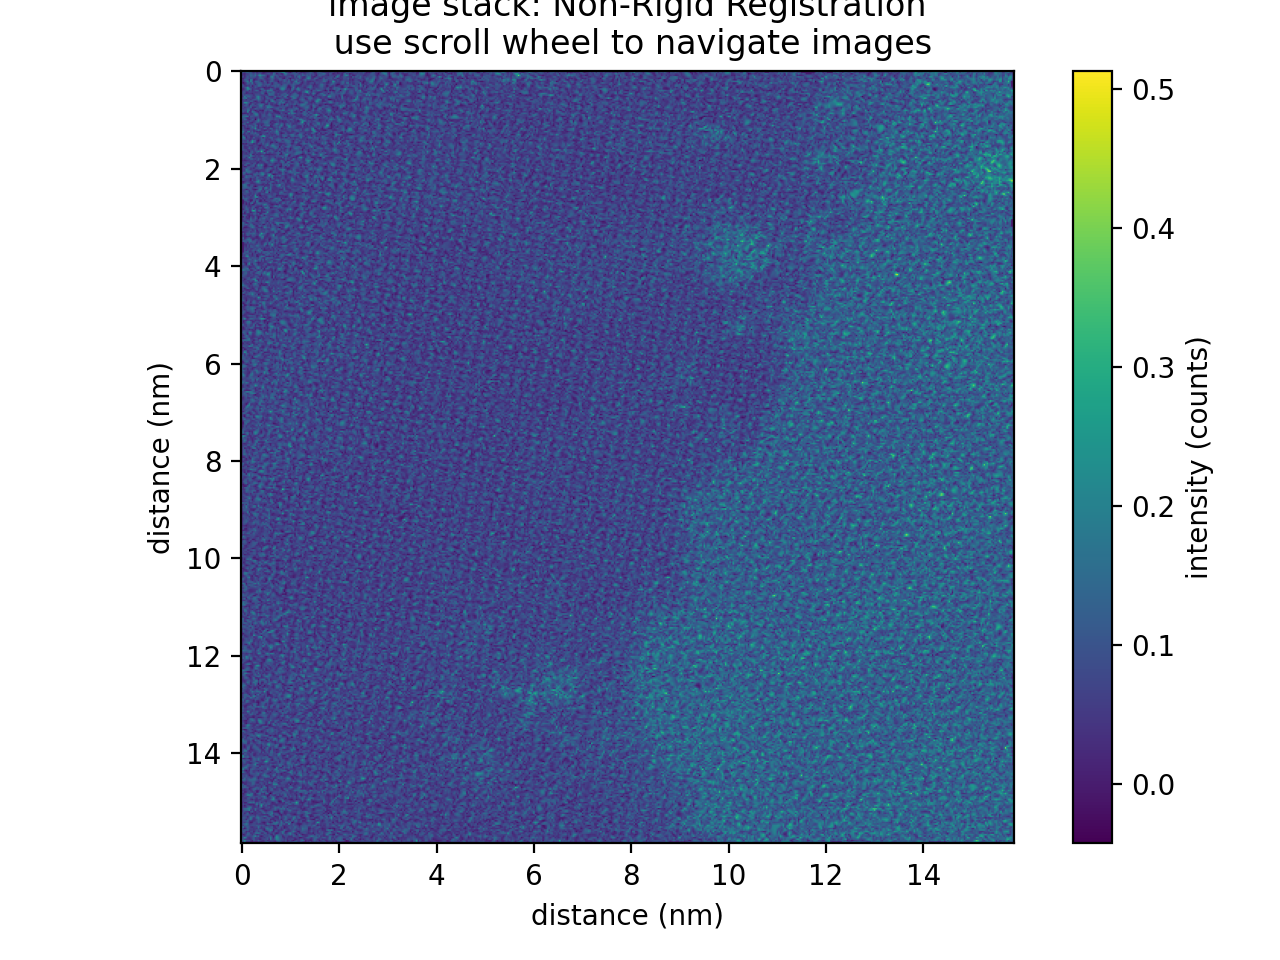

In [14]:
non_rigid_registered = it.demon_registration(rig_reg_dataset)

if bokeh_plot:
    p = plot_stack(non_rigid_registered)
    show(p)
else: 
    non_rigid_registered.plot()

### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.39


<IPython.core.display.Javascript object>


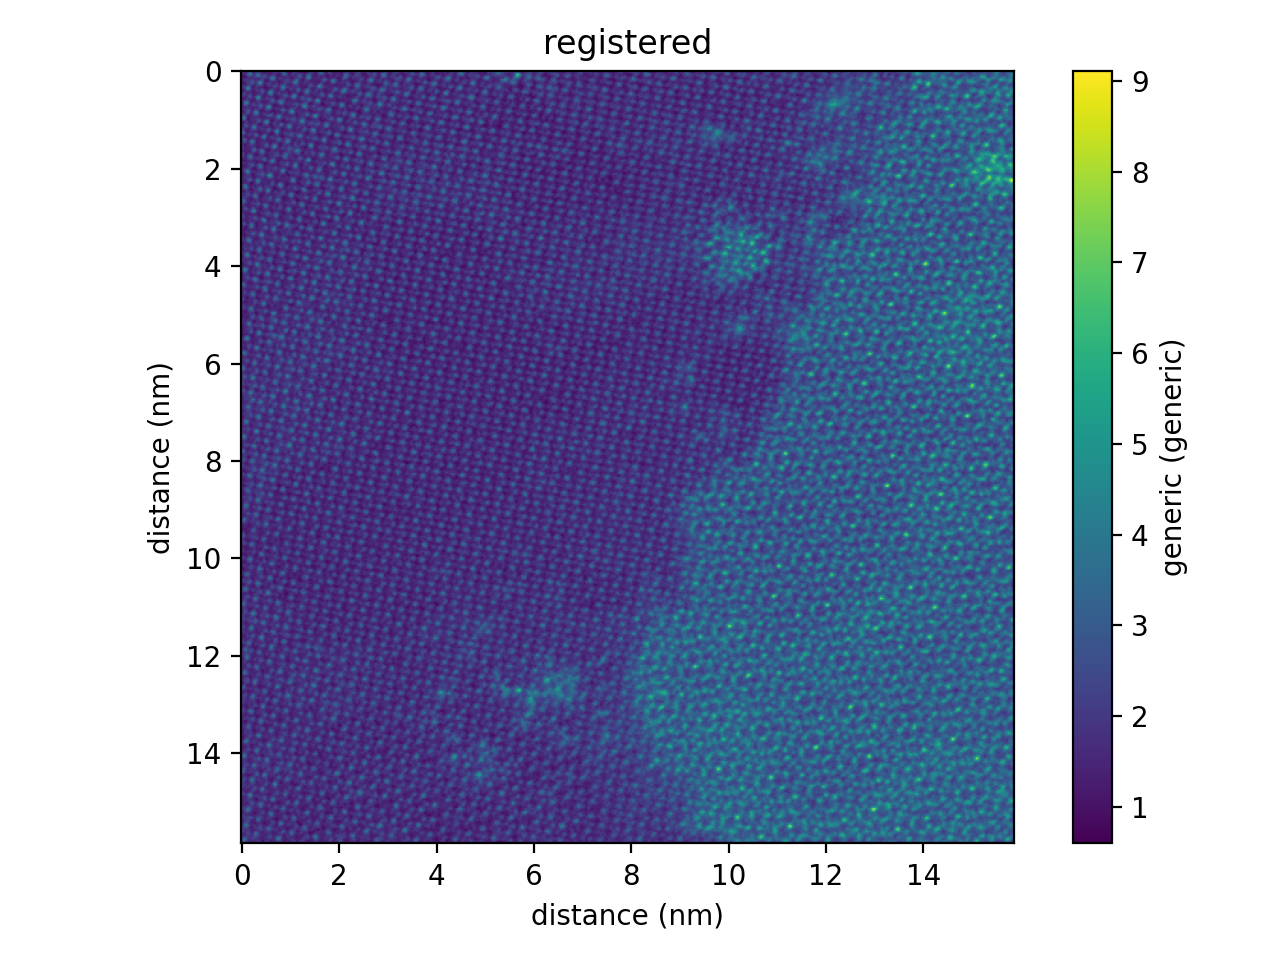

In [17]:
if non_rigid_registered.data_type.name == 'IMAGE_STACK':
    image = non_rigid_registered.sum(axis=0)
    image = sidpy.Dataset.from_array(image)
    image.data_type = 'image'
    image.title = 'registered'
    image.set_dimension(0,non_rigid_registered.dim_1)
    image.set_dimension(1,non_rigid_registered.dim_2)
else:
    image = dataset

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

if bokeh_plot:
    p = image_plot(image, palette="Cividis256")
    show(p)
else: 
    image.plot()

### Log Non-Rigid Registration

In [19]:
registration_channel = ft.log_results(dataset, non_rigid_registered)

C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_io.py:109: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:Non-Rigid Registration to Non_Rigid Registration
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\Anaconda3\lib\site-packages\sidpy\hdf\hdf_utils.py:419: UserWarning: Casting attribute value: <HDF5 dataset "Non_Rigid Registration": shape (25, 508, 508), type "<f8"> of type: <class 'h5py._hl.dataset.Dataset'> to str
  warn('Casting attribute value: {} of type: {} to str'
C:\Users\gduscher\Anaconda3\lib\site-packages\sidpy\hdf\hdf_utils.py:419: UserWarning: Casting attribute value: <sidpy.viz.dataset_viz.ImageStackVisualizer object at 0x00000286A9E02220> of type: <class 'sidpy.viz.dataset_viz.ImageStackVisualizer'> to str
  warn('Casting attribute value: {} of type: {} to str'
C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:349: FutureWarning: validate_h5_dimension may

A tree-like plot of the file

In [27]:
for key in current_channel:
    if 'Log' in key:
        for key2 in current_channel[key]:
            if '_metadata' in current_channel[key][key2]: 
                if 'analysis' in current_channel[key][key2]['_metadata'].attrs.keys():
                    print(f"{key} includes analysis: {current_channel[key][key2]['_metadata'].attrs['analysis']}")

ft.h5_tree(dataset)

Log_000 includes analysis: rigid sub-pixel registration
Log_001 includes analysis: non-rigid demon registration
Log_002 includes analysis: rigid sub-pixel registration
Log_003 includes analysis: non-rigid demon registration
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ Rigid Registration
        ------------------
        ├ Rigid Registration
        ├ __dict__
          --------
        ├ _axes
          -----
        ├ _metadata
          ---------
        ├ frame
        ├ metadata
          --------
        ├ x
        ├ y
    ├ Log_001
      -------
      ├ Non_Rigid Registration
        ----------------------
        ├ Non_Rigid Registration
        ├ __dict__
          --------
        ├ _axes
          -----
        ├ _metadata
          ---------
        ├ frame
        ├ metadata
          --------
        ├ x
        ├ y
    ├ Log_002
      -------
      ├ Rigid Registration
        ------------------
        ├ Rigi

## Comparison of Different Dataset

A convenient function to select a dataset (for further processing, visualization or whatever)

In [21]:
choose_image = ft.ChooseDataset(dataset.h5_dataset.parent.parent)

C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\nsi_reader.py:29: FutureWarning: This Reader will eventually be moved to the ScopeReaders package. Be prepared to change your import statements
  warn('This Reader will eventually be moved to the ScopeReaders package'
C:\Users\gduscher\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Dropdown(description='Select image:', options=('Recording of SuperScan (HAADF)/Recording of SuperScan (HAADF)'…

The selected dataset can then easily be plotted

<IPython.core.display.Javascript object>


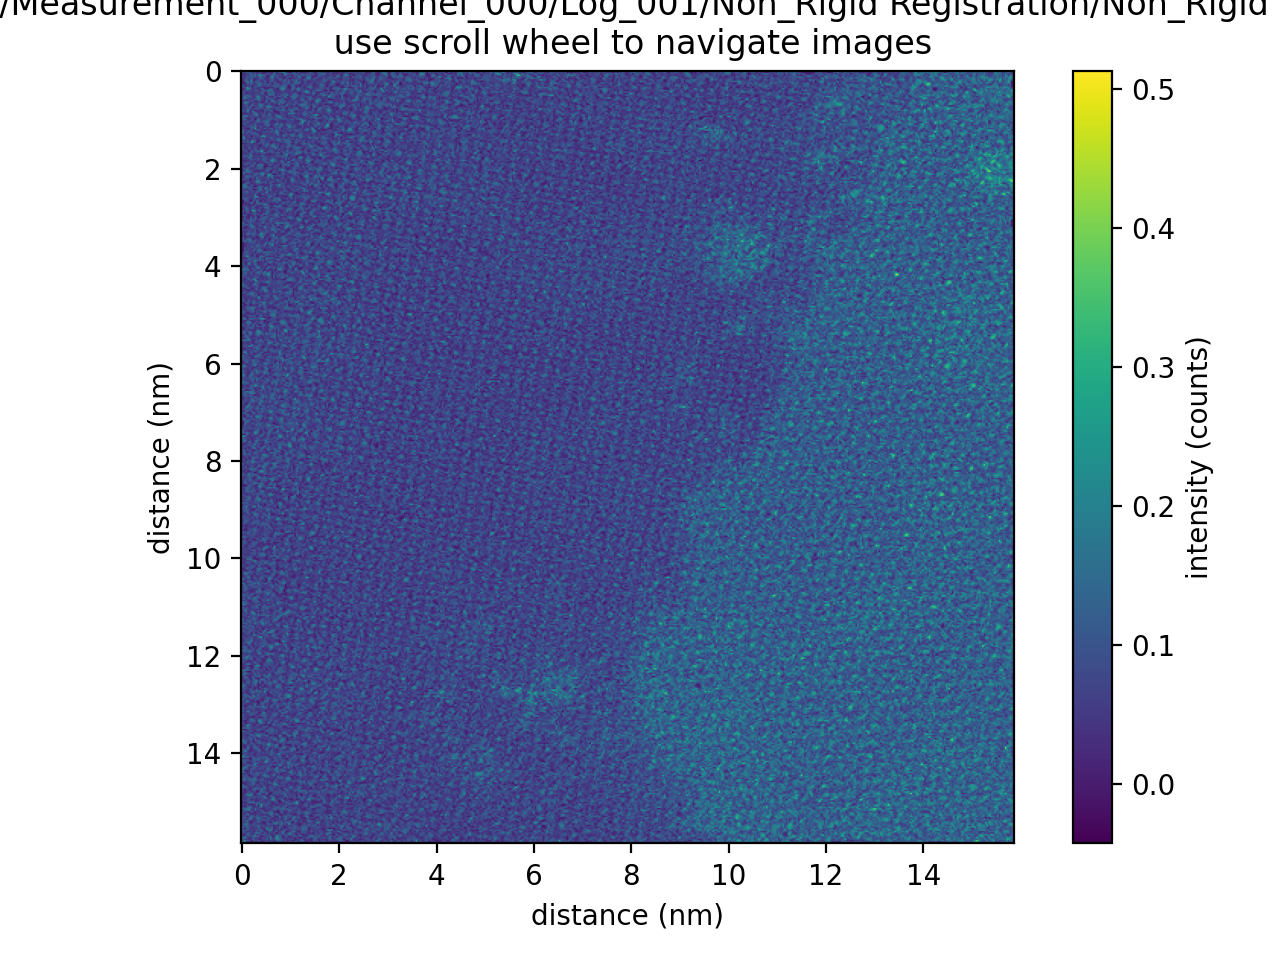

In [24]:
if bokeh_plot:
    if choose_image.dataset.ndim ==3:
        p = stack_plot(choose_image.dataset, palette="Cividis256")
    else:
        p = image_plot(choose_image.dataset, palette="Cividis256")
    show(p)
else: 
    choose_image.dataset.plot()

## Close File
let's close the file but keep the filename

In [25]:
filename = registration_channel.file.filename
registration_channel.file.close()